# Imports

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.debugger import set_trace
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

# Data Preprocessing

In [ ]:
# packaging it all into a function
def preprocess_fashion_mnist():
  import random as rand
   
   
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
  
  mean_mat = np.mean(x_train, axis=0)
  # centering the data by removing the pixel wise mean from every pixel in every image
  x_train_centered = x_train - mean_mat
  x_test_centered = x_test - mean_mat
  # normalizing the grayscale values to values in interval [0,1]
  x_train_normalized = x_train_centered/255.0
  x_test_normalized = x_test_centered/255.0

  #finally, flattening the data
  x_train = np.reshape(x_train_normalized, (60000,784))
  x_test = np.reshape(x_test_normalized, (10000, 784))
  #converting the test data to one hot encodings
  y_train = keras.utils.to_categorical(y_train, num_classes=10)
  y_test = keras.utils.to_categorical(y_test, num_classes=10)
  
  return x_train, y_train, x_test, y_test
# x_train, y_train, x_test, y_test = preprocess_fashion_mnist()

# General Model Implementations


Activation functions

In [ ]:
#activation functions
softmax1D = lambda z: np.exp(z)/float(sum(np.exp(z)))
softmax2D = lambda z: np.array([np.exp(i)/float(sum(np.exp(i))) for i in z])

# Logistic
logistic = lambda z: 1./ (1 + np.exp(-z))

# Tanh
tanh = lambda x: 2./ (1+np.exp(-2*x)) -1
tanh_grad = lambda x: 1 - np.square(2./ (1+np.exp(-2*x)) -1)

# Leaky ReLu
def leaky_relu(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  np.putmask(x, x<0, alpha*x)
  return x

def leaky_relu_grad(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=alpha
  return x

  
# ReLu
def relu(x):
  x=np.array(x).astype(float)
  np.putmask(x, x<0, 0)
  return x
  
def relu_grad(x):
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=0
  return x

Accuracy function

In [ ]:
def evaluate_acc(pred, truth):
  counter =0
  
  for i in range(len(pred)):
    maxVal = np.where(pred[i] == np.amax(pred[i]))
    counter += 1 if maxVal == np.where(truth[i]==1) else 0
  return counter * 100.0 / float(len(pred))
  

# 1 Layer MLP

In [ ]:
class MLP1Layer:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
        self.params = []
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            
            # print('x=',x.shape)
            w = params[0] # v.shape = (D, M), w.shape = (M)
            z = np.dot(x, w)# print('z=',z.shape)
            yh = softmax2D(z)#N
            dy = yh - y #N
            
            dw = np.dot(x.T, dy)/N #M  
            dparams = [dw]
            return dparams
        
        # w = np.random.randn(self.M) * .01
        # v = np.random.randn(D,self.M) * .01
        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(D, self.num_classes))
        # v = initializer(shape=(D, self.M))
        params0 = [w]
        self.params = params0

        self.params = optimizer.run(gradient, x, y, params0) #optimizer.run_mini_batch(gradient, x, y, params0) #
        # print(self.params)
        return self
    
    def predict(self, x):
        w = self.params[0]
        yh = softmax2D(np.dot(x, w))#N
        return yh

# 2 Layer MLP

In [ ]:
class MLP2Layer:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
            
    def fit(self, x, y, optimizer):
        N,D = x.shape

        def gradient(x, y, params):
            v, w = params # v.shape = (D, M), w.shape = (M)
            q = np.dot(x, v)
            z = relu(q) #N x M   
            yh = softmax2D(np.dot(z, w))#N
            acc = evaluate_acc(yh,y)
            dy = yh - y #N
            dw = np.dot(z.T, dy)/N #M  
            dz = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            temp = dz * relu_grad(q) #(1024,128) (32,128)
            dv = np.dot(x.T, dz * relu_grad(q))/N #D x M   = (yh-y)*w*(activation)'*x
            dparams = [dv, dw]
            return dparams, acc
        
        # w = np.random.randn(self.M) * .01
        # v = np.random.randn(D,self.M) * .01
        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v = initializer(shape=(D, self.M))
        params0 = [v,w]
        self.params, batch_acc = optimizer.run_mini_batch(gradient, x, y, params0, 64) #optimizer.run(gradient, x, y, params0) #
        return self, batch_acc
    
    def predict(self, x):
        v, w = self.params
        z = relu(np.dot(x, v)) #N x M
        yh = softmax2D(np.dot(z, w))#N
        return yh

# 3 Layer MLP

### 3 Layer Relu

In [ ]:
class MLP3Layer:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1) 
            z1 = relu(q1) #N x M
            q2 = np.dot(z1, v2) # N
            z2 = relu(q2)
            yh = softmax2D(np.dot(z2, w))#N
            ## Backpropagation
            ## 1st layer
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M  
            ## 2nd Layer            
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv2 = np.dot(z1.T, dz2 * relu_grad(q2))/N #D x M       = (yh-y)*w*(activation)'*x
            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                 = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * relu_grad(q1))/N #D x M        = (yh-y)*w*(activation)'*x
            dparams = [dv1, dv2, dw]
            return dparams
        
        # w = np.random.randn(self.M) * .01
        # v = np.random.randn(D,self.M) * .01
        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v2 = initializer(shape=(self.M, self.M))
        v1 = initializer(shape=(D, self.M))
        
        params0 = [v1, v2,w]
        self.params = optimizer.run_mini_batch(gradient, x, y, params0) #optimizer.run(gradient, x, y, params0)#
        return self
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

### 3 Layer MLP - Leaky ReLu

In [ ]:
class MLPLeakyRelu:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
        
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1) 
            z1 = leaky_relu(q1) #N x M
            q2 = np.dot(z1, v2) # N
            z2 = leaky_relu(q2)
            yh = softmax2D(np.dot(z2, w))#N
            ## Backpropagation
            ## 1st layer
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M  
            ## 2nd Layer                  
            # dz = np.dot(dy.T, w)
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv2 = np.dot(z1.T, dz2 * leaky_relu_grad(q2))/N #D x M   = (yh-y)*w*(activation)'*x
            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * leaky_relu_grad(q1))/N #D x M   = (yh-y)*w*(activation)'*x
            dparams = [dv1, dv2, dw]
            return dparams
        
         initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v2 = initializer(shape=(self.M, self.M))
        v1 = initializer(shape=(D, self.M))
        
        params0 = [v1, v2,w]
        self.params = optimizer.run_mini_batch(gradient, x, y, params0) #optimizer.run(gradient, x, y, params0)#
        return self
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

### 3 Layer MLP - TanH

In [ ]:
class MLPTanh:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1) 
            z1 = tanh(q1) #N x M
            q2 = np.dot(z1, v2) # N
            z2 = tanh(q2)
            yh = softmax2D(np.dot(z2, w))#N
            ## Backpropagation
            
            ## 1st layer
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M  
            
            ## 2nd Layer                  
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv2 = np.dot(z1.T, dz2 * tanh_grad(q2))/N #D x M   = (yh-y)*w*(activation)'*x
            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * tanh_grad(q1))/N #D x M   = (yh-y)*w*(activation)'*x
            dparams = [dv1, dv2, dw]
            return dparams
        
        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v2 = initializer(shape=(self.M, self.M))
        v1 = initializer(shape=(D, self.M))
        
        params0 = [v1, v2,w]
        self.params = optimizer.run_mini_batch(gradient, x, y, params0) #optimizer.run(gradient, x, y, params0)#
        return self
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

# Dropout 3-layer

In [ ]:
class MLPReluDropout:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
        
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            p2 = 0.5
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1)
            drop1 = np.random.binomial(1,p2,size=q1.shape[1])/p2 
            q1 *= drop1 
            z1 = relu(q1) #N x M

            q2 = np.dot(z1, v2) # N
            q2 *= np.random.binomial(1,p2,size=q2.shape[1])/p2
            z2 = relu(q2)
            
            yh = softmax2D(np.dot(z2, w))#N
            train_acc = evaluate_acc(yh,y)
            ## Backpropagation    
            ## 1st layer
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M  
            
            ## 2nd Layer                  
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv2 = np.dot(z1.T, dz2 * relu_grad(q2))/N #D x M   = (yh-y)*w*(activation)'*x
            
            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * relu_grad(q1))/N #D x M   = (yh-y)*w*(activation)'*x
            dparams = [dv1, dv2, dw]
            return dparams, train_acc
        
        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v2 = initializer(shape=(self.M, self.M))
        v1 = initializer(shape=(D, self.M))
        
        params0 = [v1, v2,w]
        self.params, batch_train_accs = optimizer.run_mini_batch(gradient, x, y, params0) #optimizer.run(gradient, x, y, params0)#
        return self, batch_train_accs
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

# Batch Implementation

In the implementation above we have used a list data structure to maintain model parameters and their gradients. Below I have modified the `GradientDescent` class to also work with a list of parameters. One sournce of confusion in the above implementation is the gradient calculation. While in the slides during the lectures 
we calculated the partial derivative for individual parameters, here, we use vector and matrix operations to calculate the derivative for *all* parameters. 

In [ ]:
def mini_batcher(x, y, mini_batch_size):
  zipped = np.hstack( (x, y ) )
  np.random.shuffle(zipped)
  x_batches, y_batches = [], []
  mini_batches = []
  batch_num = x.shape[0] // mini_batch_size 
  for i in range(batch_num):
    x_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, :-10]
    y_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, -10:]
    mini_batches.append( ( x_batch, y_batch) )
  if x.shape[0] % mini_batch_size != 0:
    x_batch = zipped[ batch_num * mini_batch_size :, :-10]
    y_batch = zipped[ batch_num * mini_batch_size :, -10:]
    mini_batches.append( ( x_batch, y_batch ) )
  return mini_batches

# Gradient Descent 

---



In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=800, epsilon=1e-8, batch_size=32):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        print(t)
        return params
    
    def run_mini_batch(self, gradient_fn, x, y, params, batch_size=32):
        norms = np.array([np.inf])
        t=1
        temp_acc,batch_acc, chunk= [], [], []
        mini_batches = mini_batcher(x, y, batch_size)
        print("#mini batches",len(mini_batches))
        batch_index = 0

        while np.any(norms > self.epsilon) and t < self.max_iters*len(mini_batches):
            
            if(batch_index == batch_size):
              mini_batches = mini_batcher(x, y, batch_size)
              batch_index = 0
            batch_index +=1

            x_temp, y_temp = mini_batches[t % ( len(mini_batches)-1 ) ][0], mini_batches[t % ( len(mini_batches)-1 ) ][1]
            grad, temp_acc = gradient_fn(x_temp, y_temp, params)
            chunk.append(temp_acc)
            if t % 10000 == 0:
              print(f"Epoch{t}:{temp_acc}%")

            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            if t%len(mini_batches) == 2:
              batch_acc.append(np.mean(chunk))
              chunk = []
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params, batch_acc

# Hyperparameter Tuning

In [ ]:
def hyper_tuning(model, activ, x_train, y_train):
  kf = KFold(5)
  acc_vals = []
  
  learning_rate = [0.001, 0.002, 0.004]
  batch_size = [16, 32, 64]
  for btch in batch_size:
    for lr in learning_rate:
      optimizer = GradientDescent(learning_rate = lr, batch_size=btch)
         
      avg_acc = 0;       
      for k, (train, test) in enumerate(kf.split(x_train, y_train)):
        
          temp_model = model(M=128)
          temp_model.fit(x_train[train], y_train[train], optimizer)
          y_test_pred = temp_model.predict(x_train[test])
          temp_acc = evaluate_acc(y_test_pred, y_train[test])
          avg_acc += temp_acc
      avg_acc = avg_acc/5
      acc_vals.append(avg_acc)
  data = {'learningRate' : [0.001, 0.002, 0.004, 0.001, 0.002, 0.004, 0.001, 0.002, 0.004], 
          'batchSize':[16, 16, 16, 32, 32, 32, 64, 64, 64],
          'C':[100.0, 10.0, 1.0, .01, 100.0, 10.0, 1.0, .01,
               100.0, 10.0, 1.0, .01, 100.0, 10.0, 1.0, .01,
               100.0, 10.0, 1.0, .01, 100.0, 10.0, 1.0, .01,
               100.0, 10.0, 1.0, .01, 100.0, 10.0, 1.0, .01, 100.0, 10.0, 1.0, .01],
          'accuracies': acc_vals
          }
  acc = pd.DataFrame(data)
  print(acc)
  return acc

# MNIST DataSet
---

## Model1 - No hidden layers

In [ ]:
x_train, y_train, x_test, y_test = preprocess_fashion_mnist()

optimizer1 = GradientDescent(learning_rate=.001)
model1 = MLPReluDropout(M=256, num_classes=10)
y_pred, batch_acc = model1.fit(x_train[:10000], y_train[:10000], optimizer1)
y_test_pred = model1.predict(x_test)

Epoch10000:6.25%
Epoch20000:9.375%
Epoch30000:6.25%
Epoch40000:9.375%
Epoch50000:6.25%
Epoch60000:15.625%
Epoch70000:15.625%
Epoch80000:12.5%
Epoch90000:9.375%
Epoch100000:28.125%
Epoch110000:15.625%
Epoch120000:25.0%
Epoch130000:25.0%
Epoch140000:15.625%
Epoch150000:28.125%
Epoch160000:21.875%
Epoch170000:40.625%
Epoch180000:25.0%
Epoch190000:18.75%
Epoch200000:21.875%
Epoch210000:28.125%
Epoch220000:21.875%
Epoch230000:21.875%
Epoch240000:31.25%
Epoch250000:25.0%


No handles with labels found to put in legend.


Number of full training batch iterations: 800
Accuracies per training batch:
4.6875
10.613019169329073
10.283546325878595
10.323482428115016
10.253594249201278
10.223642172523961
11.222044728434504
10.353434504792332
10.53314696485623
10.702875399361023
10.782747603833865
10.023961661341852
10.742811501597444
10.952476038338657
10.632987220447284
10.243610223642172
11.25199680511182
10.872603833865815
10.872603833865815
10.513178913738018
10.88258785942492
10.40335463258786
11.022364217252397
10.75279552715655
10.463258785942491
10.413338658146964
10.762779552715655
10.593051118210862
11.062300319488818
11.182108626198083
10.483226837060704
10.892571884984026
10.473242811501597
11.242012779552716
10.99241214057508
11.172124600638977
10.583067092651758
11.521565495207668
11.271964856230031
10.413338658146964
11.132188498402556
11.10223642172524
10.822683706070288
11.311900958466454
10.333466453674122
10.982428115015974
11.032348242811501
11.501597444089457
10.932507987220447
11.05231629

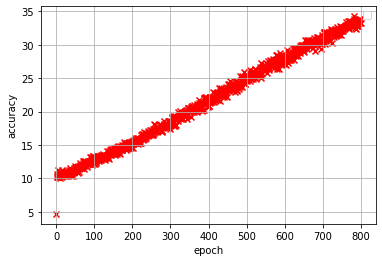

57.02


In [ ]:
print("Number of full training batch iterations:",len(batch_acc))
print("Accuracies per training batch:")
for i in batch_acc:
  print(i)
print("---------")
fig, ax = plt.subplots()
ax.scatter(range(len(batch_acc)), batch_acc, c='r', marker='x')
ax.legend()
ax.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
print(evaluate_acc(y_test_pred, y_test))

In [ ]:
evaluate_acc(y_test_pred, y_test)

57.02

In [ ]:
accM1L1 = evaluate_acc(y_test_pred, y_test)
accM1L1

62.12

## Model 2 - 1 hidden layer


In [ ]:
model2 = MLP2Layer(M=128, num_classes=10)
y_pred = model2.fit(x_train[:100], y_train[:100], optimizer1)

In [ ]:
y_test_pred = model1.predict(x_test)

In [ ]:
accM1L1 = evaluate_acc(y_test_pred, y_test)
accM1L1

55.25

**k-fold cross validation**

In [ ]:
hyper_tuning(MLP3Layer, activ = relu, x_train=x_train[:100], y_train=y_train[:100])

66.0 accuracy for M=128, nonlinearity=<function relu at 0x7f901e921ef0>, lr=0.001, batch size=16.
68.0 accuracy for M=128, nonlinearity=<function relu at 0x7f901e921ef0>, lr=0.002, batch size=16.
64.0 accuracy for M=128, nonlinearity=<function relu at 0x7f901e921ef0>, lr=0.004, batch size=16.
69.0 accuracy for M=128, nonlinearity=<function relu at 0x7f901e921ef0>, lr=0.001, batch size=32.
66.0 accuracy for M=128, nonlinearity=<function relu at 0x7f901e921ef0>, lr=0.002, batch size=32.
67.0 accuracy for M=128, nonlinearity=<function relu at 0x7f901e921ef0>, lr=0.004, batch size=32.


# Model 3 - 2 Hidden Layers


In [ ]:
tuningAccRelu = hyper_tuning(MLPLeakyRelu, activ = relu, x_train=x_train[:100], y_train=y_train[:100])

In [ ]:
hyper_tuning(MLPLeakyRelu, activ = relu, x_train=x_train[:100], y_train=y_train[:100])